## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [61]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd
import re
import sys
sys.path.append('waveglow/')
import numpy as np
import torch
import soundfile as sf
#sys.path.append('C:\\Users\\G8\\Documents\\cloned tacotron\\tacotron2\\hparams')

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
# from denoiser import Denoiser
from waveglow.denoiser import Denoiser


# input_text = sys.argv[1]
input_text = """Good afternoon every one, in today's presentation they will take you through my audiobook generation technology. Over the past few months, my team has been dedicated to developing a Text to speech synthesis model that uses advanced machine learning technology the details of which will be shortly explained. My colleague will now kickoff with a short introduction. Please take your seats and enjoy the presentation."""






In [62]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='upper', 
                       interpolation='none')

#### Setup hparams

In [63]:
hparams = create_hparams()
hparams['sampling_rate'] = 22050  # Use dictionary notation


#### Load model from checkpoint

In [64]:
#checkpoint_path = "tacotron2_statedict.pt"
checkpoint_path = "checkpoint_133000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [65]:
waveglow_path = 'waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [66]:
def segment_text(text, max_length):
    # Split the text into sentences
    sentences = re.split(r'(?<=[.!?]) +', text)
    
    segments = []
    current_segment = ""

    for sentence in sentences:
        # Check if adding the next sentence exceeds the maximum length
        if len(current_segment) + len(sentence) <= max_length:
            current_segment += sentence + " "
        else:
            # If the segment reaches the maximum length, add it to the list
            segments.append(current_segment.strip())
            current_segment = sentence + " "

    # Add the last segment if it's not empty
    if current_segment:
        segments.append(current_segment.strip())

    return segments

# Example usage
full_text = input_text
#full_text = """There was something off. I couldn’t put my finger on what exactly it was, but it was definitely there. Yes, something was out of balance, I decided as I stepped off the bus and onto the sidewalk outside John F Kennedy Prep The place looked like it did almost every other day, with its red bricks, bright-colored banners strung up everywhere, and the jumble of students lingering around outside the front doors. The school had been around for more than a century, and it had that Old New York feel. Nothing was ever out of the ordinary. Yet the gray clouds rolling in across the sky felt smothering, bringing with them a feeling of suspicion and . . . sadness. An almost suffocating sadness. New York was the city that never slept, the place that had a thousand different attitudes. But I’d never felt one like this before. “C’mon, Hadley, you’re in the way.” I quickly moved to the side as Taylor Lewis, my best friend, sauntered off the bus. I first met Taylor during freshman orientation, when I’d been wandering the halls alone while looking for my classes. From that moment onward, she’d decided to take me under her wing because we were both wearing the same shirt from American Apparel, and decided to teach me everything she already knew about the social scene at JFK. Without her, I would have been totally lost—literally, figuratively, and most certainly socially. Now, more than two years later, we were still best friends, and I was still content to hang out in Taylor’s social-butterfly shadow."""
max_length = 380  # Set this based on your benchmark

text_segments = segment_text(full_text, max_length)


In [67]:
# text = """There was something off. I couldn’t put my finger on what exactly it was, but it was definitely there. Yes, something was out of balance, I decided as I stepped off the bus and onto the sidewalk outside John F Kennedy Prep The place looked like it did almost every other day, with its red bricks,bright-colored banners strung up everywhere, and the jumble of students lingering around outside the doors. """
# sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
# sequence = torch.autograd.Variable(

#  torch.from_numpy(sequence)).cuda().long()


# #there was something off.I couldn't put my finger on what exactly it was, but it was definitely there. Yes, something was out of balance, I decided as I stepped off the bus and onto the sidewalk outside John F. Kennedy Prep. The place looked like it did almost every other day, with its red bricks, bright-colored banners strung up everywhere, and the jumble of students lingering around outside the front doors. 

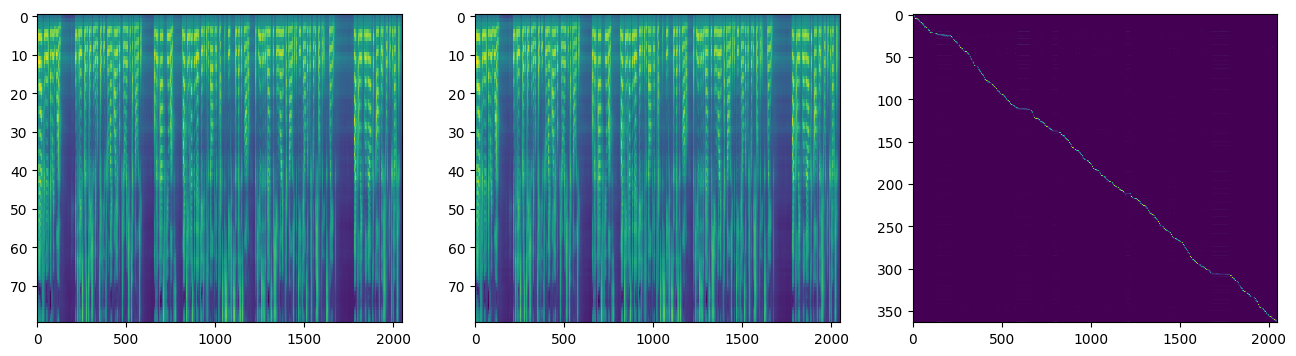

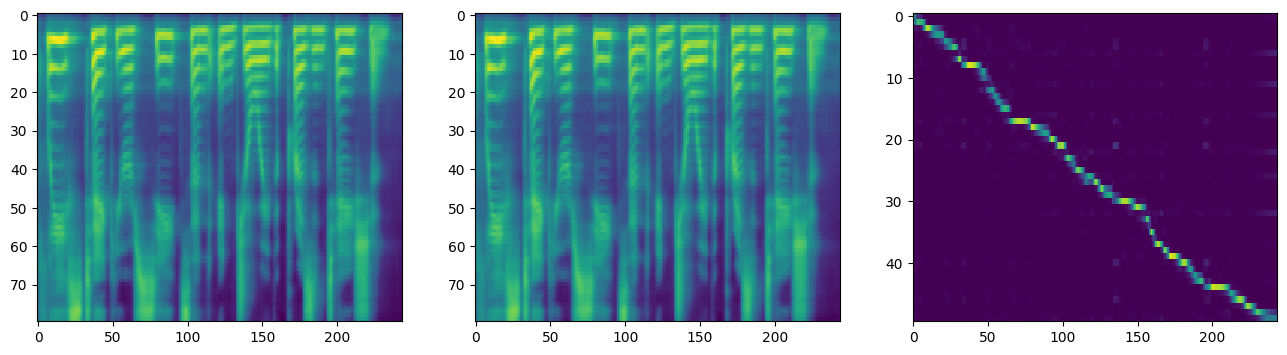

In [68]:
for segment in text_segments:
    sequence = np.array(text_to_sequence(segment, ['english_cleaners']))[None, :]
    sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()

    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
    
    # Plotting the Mel Spectrograms
    plot_data((mel_outputs.float().data.cpu().numpy()[0],
               mel_outputs_postnet.float().data.cpu().numpy()[0],
               alignments.float().data.cpu().numpy()[0].T))


#### Decode text input and plot results

In [69]:
# mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
# plot_data((mel_outputs.float().data.cpu().numpy()[0],
#            mel_outputs_postnet.float().data.cpu().numpy()[0],
#            alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [70]:
for i, segment in enumerate(text_segments):
    # Generate the mel spectrogram for the current segment
    sequence = np.array(text_to_sequence(segment, ['english_cleaners']))[None, :]
    sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

    # Generate audio from the mel spectrogram
    with torch.no_grad():
        audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)

    # Play the audio inline
    ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams['sampling_rate'])


In [71]:
# with torch.no_grad():
#     audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
# ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams['sampling_rate'])




#### (Optional) Remove WaveGlow bias

In [72]:
for i, segment in enumerate(text_segments):
    # Generate the mel spectrogram for the current segment
    sequence = np.array(text_to_sequence(segment, ['english_cleaners']))[None, :]
    sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
    mel_outputs, mel_outputs_postnet, _, _ = model.inference(sequence)

    # Generate audio from the mel spectrogram
    with torch.no_grad():
        audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)

    # Apply denoising to the generated audio
    audio_denoised = denoiser(audio, strength=0.01)[:, 0]

    # Define the path to save the denoised audio file
    output_path = f'C:\\Users\\G8\\Desktop\\denoised_audio_output_segment_{i+1}.wav'

    # Convert the denoised audio tensor to a numpy array and flatten it
    audio_denoised_numpy = audio_denoised.cpu().numpy().astype('float32').flatten()

    # Save the denoised audio to a file
    sf.write(output_path, audio_denoised_numpy, hparams['sampling_rate'])

    # Play the denoised audio inline
    ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams['sampling_rate'])


Warning! Reached max decoder steps


In [73]:

    # audio_denoised = denoiser(audio, strength=0.01)[:, 0]
    # ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams['sampling_rate'])


In [74]:
# import soundfile as sf

# with torch.no_grad():
#   audio_denoised = denoiser(audio, strength=0.01)[:, 0]


# # Define the path to save the file
# output_path = 'C:\\Users\\G8\\Desktop\\audio_output5_1.wav'

# # Convert tensor to numpy array and flatten

# audio_numpy =audio_denoised.cpu().numpy().astype('float32').flatten()

# # Save the audio to a file
# sf.write(output_path, audio_numpy, hparams['sampling_rate'])

In [78]:
# List of audio file paths
audio_files = [f'C:\\Users\\G8\\Desktop\\denoised_audio_output_segment_{i+1}.wav' for i in range(len(text_segments))]

# Initialize an empty list to hold the audio data
concatenated_audio = []

# Read each audio file and append its data to the list
for file in audio_files:
    audio, sample_rate = sf.read(file)
    concatenated_audio.append(audio)

# Concatenate the audio data from all files
concatenated_audio = np.concatenate(concatenated_audio, axis=0)

# Define the path for the concatenated audio file
output_concatenated_path = 'C:\\Users\\G8\\Desktop\\ThesisFrontend\\audiobook\\outputAudio\\concatenated_audio_output_f.wav'

# Save the concatenated audio to the file
sf.write(output_concatenated_path, concatenated_audio, sample_rate)
